AI-Driven Relationship Compatibility Prediction
(End-to-End, Explainable, Real Human Data)


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

from xgboost import XGBClassifier
import shap


🔹 STEP 1: LOAD DATA

In [2]:
df = pd.read_csv(
    r"E:\Relationship AI\data\raw\speed_dating_data.csv",
    encoding="latin1"
)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (8378, 195)


,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


🔹 STEP 2: TARGET DISTRIBUTION

In [3]:
df['dec'].value_counts(normalize=True)


dec
0    0.580091
1    0.419909
Name: proportion, dtype: float64

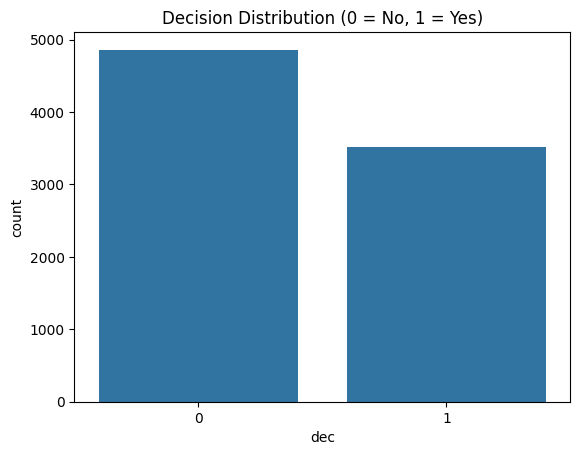

In [4]:
sns.countplot(x='dec', data=df)
plt.title("Decision Distribution (0 = No, 1 = Yes)")
plt.show()


🔹 STEP 3: SELECT SAFE COLUMNS
(NO LEAKAGE)

In [5]:
selected_cols = [
    'dec',

    # Partner ratings
    'attr', 'sinc', 'intel', 'fun', 'amb', 'shar',

    # User preferences (before dating)
    'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',

    # Reality constraints
    'age', 'age_o', 'int_corr', 'samerace'
]

df = df[selected_cols].copy()
print(df.shape)


(8378, 17)


🔹 STEP 4: RENAME COLUMNS

In [6]:
df = df.rename(columns={
    'dec': 'decision',

    'attr': 'rating_attractiveness',
    'sinc': 'rating_sincerity',
    'intel': 'rating_intelligence',
    'fun': 'rating_fun',
    'amb': 'rating_ambition',
    'shar': 'rating_interests',

    'attr1_1': 'pref_attractiveness',
    'sinc1_1': 'pref_sincerity',
    'intel1_1': 'pref_intelligence',
    'fun1_1': 'pref_fun',
    'amb1_1': 'pref_ambition',
    'shar1_1': 'pref_interests',

    'age': 'user_age',
    'age_o': 'partner_age',
    'samerace': 'same_race',
    'int_corr': 'interest_correlation'
})


🔹 STEP 5: HANDLE MISSING VALUES

In [7]:
df.isnull().sum()


decision                    0
rating_attractiveness     202
rating_sincerity          277
rating_intelligence       296
rating_fun                350
rating_ambition           712
rating_interests         1067
pref_attractiveness        79
pref_sincerity             79
pref_intelligence          79
pref_fun                   89
pref_ambition              99
pref_interests            121
user_age                   95
partner_age               104
interest_correlation      158
same_race                   0
dtype: int64

In [8]:
for col in df.columns:
    df[col] = df[col].fillna(df[col].median())


🔹 STEP 6: BASIC CLEANING

In [9]:
df = df[df['user_age'] < 60]
df.shape

(8378, 17)

🔹 STEP 7: FEATURE ENGINEERING (CORE INTELLIGENCE)

In [10]:
traits = [
    'attractiveness',
    'sincerity',
    'intelligence',
    'fun',
    'ambition',
    'interests'
]

for t in traits:
    df[f'{t}_match_index'] = (
        df[f'rating_{t}'] * df[f'pref_{t}']
    )


🔹 Age Gap

In [11]:
df['age_diff'] = abs(df['user_age'] - df['partner_age'])

🔹 Final Feature Set (CLEAN & STRONG)

In [12]:
# final_features = [
#     'decision',

#     'attractiveness_match_index',
#     'sincerity_match_index',
#     'intelligence_match_index',
#     'fun_match_index',
#     'ambition_match_index',
#     'interests_match_index',

#     'age_diff',
#     'same_race',
#     'interest_correlation'
# ]

# df_final = df[final_features].copy()


In [13]:
# final_features = [
#     'decision',

#     # RAW RATINGS
#     'rating_attractiveness',
#     'rating_sincerity',
#     'rating_intelligence',
#     'rating_fun',
#     'rating_ambition',
#     'rating_interests',

#     # USER PREFERENCES
#     'pref_attractiveness',
#     'pref_sincerity',
#     'pref_intelligence',
#     'pref_fun',
#     'pref_ambition',
#     'pref_interests',

#     # MATCH INDEX (engineered interaction)
#     'attractiveness_match_index',
#     'sincerity_match_index',
#     'intelligence_match_index',
#     'fun_match_index',
#     'ambition_match_index',
#     'interests_match_index',

#     # CONTEXT FEATURES
#     'age_diff',
#     'same_race',
#     'interest_correlation'
# ]

# df_final = df[final_features].copy()


In [14]:
# final_features = [
#     'decision',

#     # RAW RATINGS (STRONGEST SIGNAL)
#     'rating_attractiveness',
#     'rating_sincerity',
#     'rating_intelligence',
#     'rating_fun',
#     'rating_ambition',
#     'rating_interests',

#     # USER PREFERENCES (SECONDARY SIGNAL)
#     'pref_attractiveness',
#     'pref_sincerity',
#     'pref_intelligence',
#     'pref_fun',
#     'pref_ambition',
#     'pref_interests',

#     # CONTEXT (WEAK BUT KEEP 1)
#     'interest_correlation'
# ]

# df_final = df[final_features].copy()


In [15]:
final_features = [
    'decision',

    # Ratings
    'rating_attractiveness',
    'rating_sincerity',
    'rating_intelligence',
    'rating_fun',
    'rating_ambition',
    'rating_interests',

    # Preferences
    'pref_attractiveness',
    'pref_sincerity',
    'pref_intelligence',
    'pref_fun',
    'pref_ambition',
    'pref_interests',

    # CONTEXT (INDIA-RELEVANT)
    'interest_correlation',
    'age_diff',
    'same_race'
]

df_final = df[final_features].copy()


🔹 STEP 8: CORRELATION HEATMAP

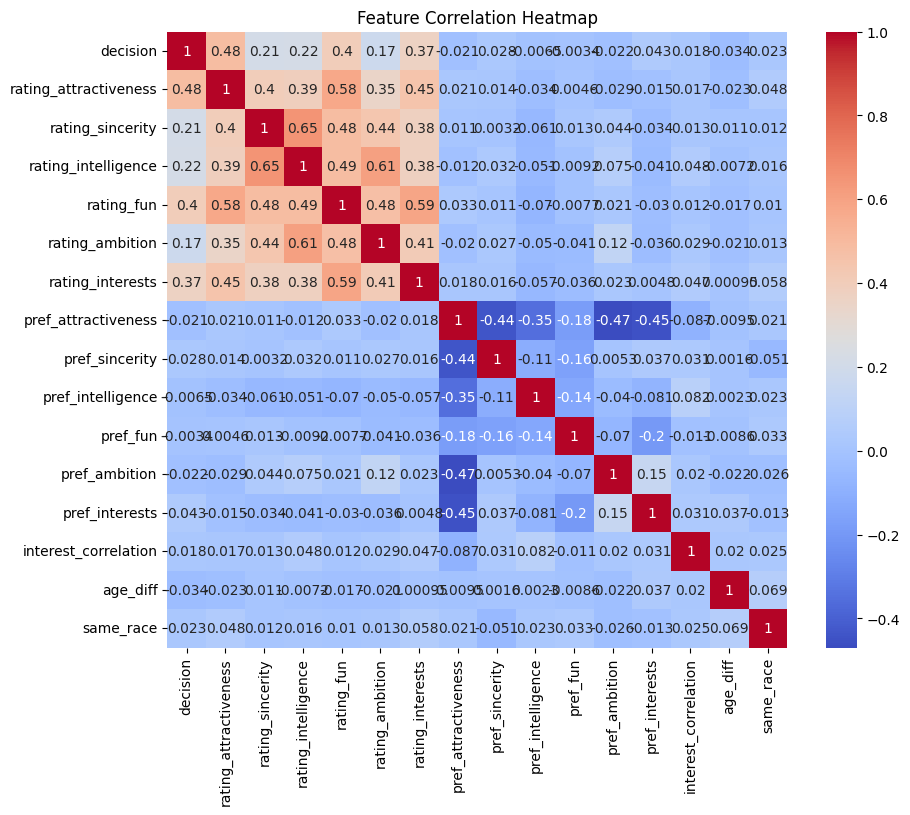

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(df_final.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


🔹 STEP 9: TRAIN–TEST SPLIT

In [17]:
X = df_final.drop(columns='decision')
y = df_final['decision']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


🔹 STEP 10: XGBOOST MODEL

In [18]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

🔹 STEP 11: EVALUATION

In [19]:
preds = xgb.predict(X_test)
probs = xgb.predict_proba(X_test)[:,1]

print(classification_report(y_test, preds))
print("ROC-AUC:", roc_auc_score(y_test, probs))


              precision    recall  f1-score   support

           0       0.82      0.83      0.82       972
           1       0.76      0.74      0.75       704

    accuracy                           0.79      1676
   macro avg       0.79      0.78      0.79      1676
weighted avg       0.79      0.79      0.79      1676

ROC-AUC: 0.8769509329405164


In [20]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.3, 0.7, 0.01)
best_f1 = 0
best_t = 0.5

for t in thresholds:
    temp_preds = (probs >= t).astype(int)
    f1 = f1_score(y_test, temp_preds)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold:", best_t)
print("Best F1:", best_f1)


Best threshold: 0.34
Best F1: 0.7660636306924516


🔹 STEP 12: ROC CURVE (ADVANCED GRAPH)

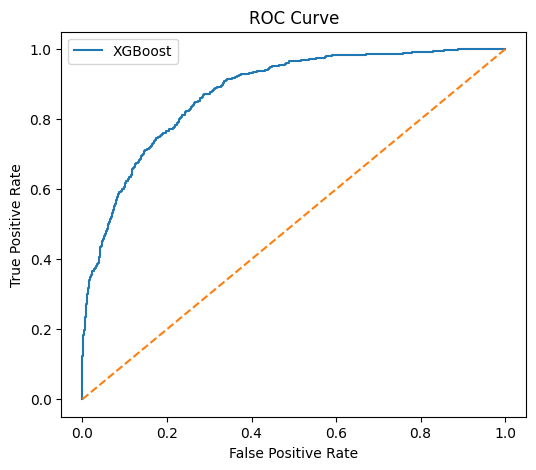

In [21]:
fpr, tpr, _ = roc_curve(y_test, probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="XGBoost")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


🔹 STEP 13: CONFUSION MATRIX

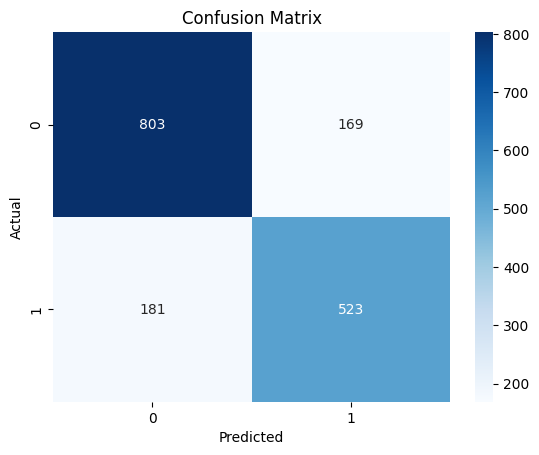

In [22]:
sns.heatmap(
    confusion_matrix(y_test, preds),
    annot=True, fmt='d', cmap='Blues'
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


🔹 STEP 14: SHAP EXPLAINABILITY (TOP TIER 🔥)

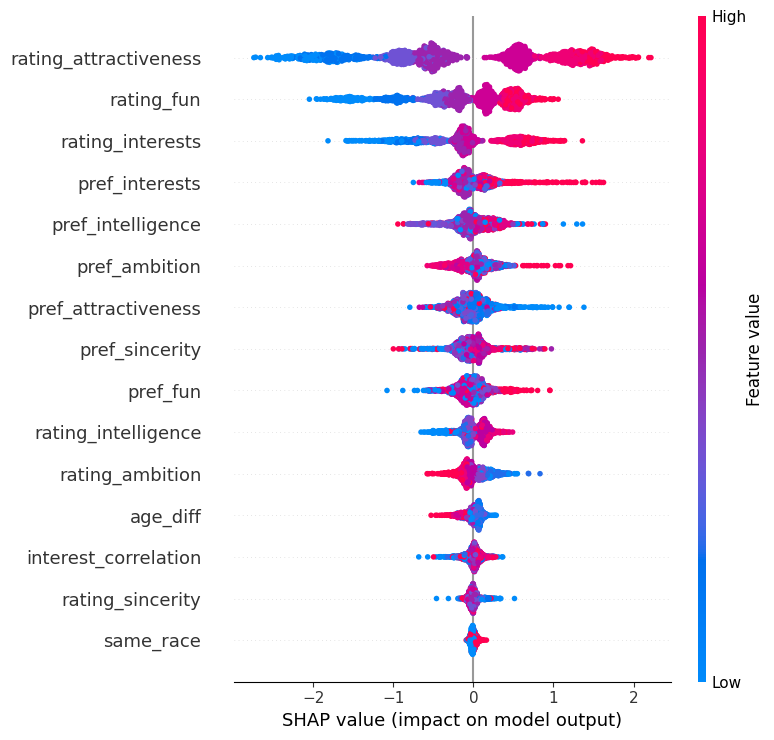

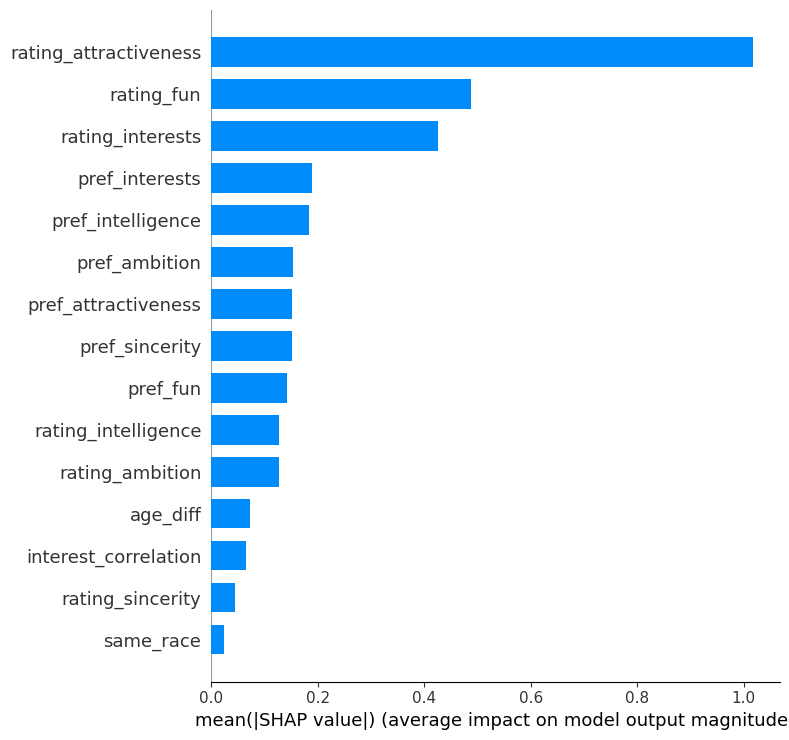

In [23]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [24]:
import joblib
joblib.dump(xgb, "xgb_model.pkl")


['xgb_model.pkl']